In [1]:
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv('data/events.csv', low_memory=False)
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [17]:
events_df = df.copy()

In [18]:
products = events_df.loc[events_df['event']=='checkout']
products = products[['timestamp', 'person', 'model', 'condition', 'color', 'storage']]

In [19]:
products = products.sort_values(by=['person', 'timestamp'])

In [20]:
products.head()

,timestamp,person,model,condition,color,storage
1507286,2018-05-17 12:27:47,0008ed71,Samsung Galaxy S6 Flat,Muito Bom,Dourado,32GB
1507716,2018-05-17 13:45:00,0008ed71,iPhone SE,Bom,Cinza espacial,64GB
1505383,2018-05-17 16:28:37,0008ed71,LG G4 H818P,Bom,Preto,32GB
208585,2018-05-20 00:41:36,00091926,iPhone 6S,Excelente,Dourado,64GB
213543,2018-05-26 00:30:47,00091926,iPhone 6S,Muito Bom,Ouro Rosa,64GB


,timestamp,person,model,condition,color,storage
1507286,2018-05-17 12:27:47,0008ed71,Samsung Galaxy S6 Flat,Muito Bom,Dourado,32GB
1507716,2018-05-17 13:45:00,0008ed71,iPhone SE,Bom,Cinza espacial,64GB
1505383,2018-05-17 16:28:37,0008ed71,LG G4 H818P,Bom,Preto,32GB
208585,2018-05-20 00:41:36,00091926,iPhone 6S,Excelente,Dourado,64GB
213543,2018-05-26 00:30:47,00091926,iPhone 6S,Muito Bom,Ouro Rosa,64GB


In [21]:
user_fff78145 = events_df.loc[events_df['person']=='ffed0342', :]

In [22]:
user_fff78145.loc[user_fff78145['event']=='conversion']

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
624458,2018-03-11 22:55:43,conversion,ffed0342,NaN,423.0,Samsung Galaxy S5 Duos,Muito Bom,16GB,Preto,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
624458,2018-03-11 22:55:43,conversion,ffed0342,NaN,423.0,Samsung Galaxy S5 Duos,Muito Bom,16GB,Preto,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Varianza de productos checkouteados:

La idea general con la que encaro esta feature es: 

    Una persona que esta decidida a comprar un modelo de teléfono, lo que va a querer definir son las características del teléfono que quiere comprar, es decir: el estado, el color y el storage del mismo. 
    
    Mi idea es encodear de alguna manera los modelos y sus características, luego hacer cierta cuenta entre ellos, para que al encontrar la std del resultado de la cuenta nos diga qué tan distintas son las cosas por las que el usuario se interesa. Sienod así un usuario que mira un iPhone 5s de color blanco, con calidad buena, pero cambia unicamente el storage, nos da una noción de interes de compra. 
    
    Otra cosa que nos permite esto, es que el desvío sea bajo también cuándo el usuario esta interesado en distintos modelos pero con las mismas características. Por ejemplo, si esta mirando un iPhone 6s o un iPhone 5s con el mismo color, storage y estado, podríamos entender que tiene interes de compra.
    
TO DO: 

    1- Ver como funciona esta idea para sesiones de usuarios. No es lo mismo que vea 5 modelos que parecen distintos a que vea 3 modelos parecidos en una siesión y 2 parecidos en otra
    
    2- Cambiar el tipo de evento para el cual estamos evaluando. Ahora siempre filtramos por checkout.

#### Mean encoding de modelos de telefonos

In [23]:
events = events_df
labels = pd.read_csv('data/labels_training_set.csv', low_memory=False, index_col='person')
events_and_labels = events.join(labels, on='person', how='inner')

events_and_labels = events_and_labels.loc[events_and_labels['event']=='checkout', :]

# events_and_labels

## Debería filtrar los eventos para no bajar la probabilidad de compra para cada caracteristica ? 

In [24]:
def get_encoding_df(df, category):
    new_df = df.loc[df[category]!=np.nan, :].groupby(category).agg({'label':['sum', 'count']})
    new_df.columns = ['sum', 'count']
    new_df['encoding'] = new_df['sum'] / new_df['count']
    return new_df[['encoding']]

In [25]:
color_encoding = get_encoding_df(events_and_labels, 'color')
model_encoding = get_encoding_df(events_and_labels, 'model')
storage_encoding = get_encoding_df(events_and_labels, 'storage')
condition_encoding = get_encoding_df(events_and_labels, 'condition')

In [29]:
condition_encoding.to_csv('data/condition_encoding.csv')
storage_encoding.to_csv('data/storage_encoding.csv')
model_encoding.to_csv('data/model_encoding.csv')
color_encoding.to_csv('data/color_encoding.csv')

Ahora que tengo el encoding de las características de los teléfonos. Hay que combinarlas de tal manera que 2 telefonos parecidos nos terminen dando algo parecido. 

In [30]:
products = products.loc[products['timestamp'] > pd.to_datetime('2018-05-15'),:]  # me quedo con checkouts de los ultimos 15 dias
                                                                                 # antes del 2018-06-01
products.head()

,timestamp,person,model,condition,color,storage
1507286,2018-05-17 12:27:47,0008ed71,Samsung Galaxy S6 Flat,Muito Bom,Dourado,32GB
1507716,2018-05-17 13:45:00,0008ed71,iPhone SE,Bom,Cinza espacial,64GB
1505383,2018-05-17 16:28:37,0008ed71,LG G4 H818P,Bom,Preto,32GB
208585,2018-05-20 00:41:36,00091926,iPhone 6S,Excelente,Dourado,64GB
213543,2018-05-26 00:30:47,00091926,iPhone 6S,Muito Bom,Ouro Rosa,64GB


,timestamp,person,model,condition,color,storage
1507286,2018-05-17 12:27:47,0008ed71,Samsung Galaxy S6 Flat,Muito Bom,Dourado,32GB
1507716,2018-05-17 13:45:00,0008ed71,iPhone SE,Bom,Cinza espacial,64GB
1505383,2018-05-17 16:28:37,0008ed71,LG G4 H818P,Bom,Preto,32GB
208585,2018-05-20 00:41:36,00091926,iPhone 6S,Excelente,Dourado,64GB
213543,2018-05-26 00:30:47,00091926,iPhone 6S,Muito Bom,Ouro Rosa,64GB


In [31]:

model_encoding_mean = np.mean(model_encoding['encoding'])

model_encodings = {row[0]: row[1]['encoding'] for row in model_encoding.iterrows()}
condition_encodings = {row[0]: row[1]['encoding'] for row in condition_encoding.iterrows()}
color_encodings = {row[0]: row[1]['encoding'] for row in color_encoding.iterrows()}
storage_encodings = {row[0]: row[1]['encoding'] for row in storage_encoding.iterrows()}

model_weight = 1
condition_weight = 1
color_weight = 1
storage_weight = 1

def encode_model(row):
    
    model = model_encodings.get(row[2], model_encoding_mean)
    condition = condition_encodings.get(row[3])
    color = color_encodings.get(row[4])
    storage = storage_encodings.get(row[5])
    
    return (model * model_weight + condition * condition_weight + color * color_weight + storage * storage_weight)

In [32]:
# paciencia que tarda un poquito estee...

products['encoding'] = products.apply(encode_model, axis=1)

In [36]:
std_products_checkedout = products.groupby('person').agg({'encoding':['std', 'mean', 'count', 'max', 'min', 'sum']})

mean_fix = np.mean(std_products_checkedout)

std_products_checkedout = std_products_checkedout.replace(np.nan, mean_fix)
std_products_checkedout.columns = ['encoding_std', 'encoding_mean', 
                                   'checked_out', 'encoding_max', 
                                   'encoding_min', 'encoding_sum'
]
stats = std_products_checkedout.join(labels, on='person', how='inner')

# descomentar esta linea para guardar el csv con las features encotradas.

std_products_checkedout.to_csv('data/std_checkouted_products.csv')

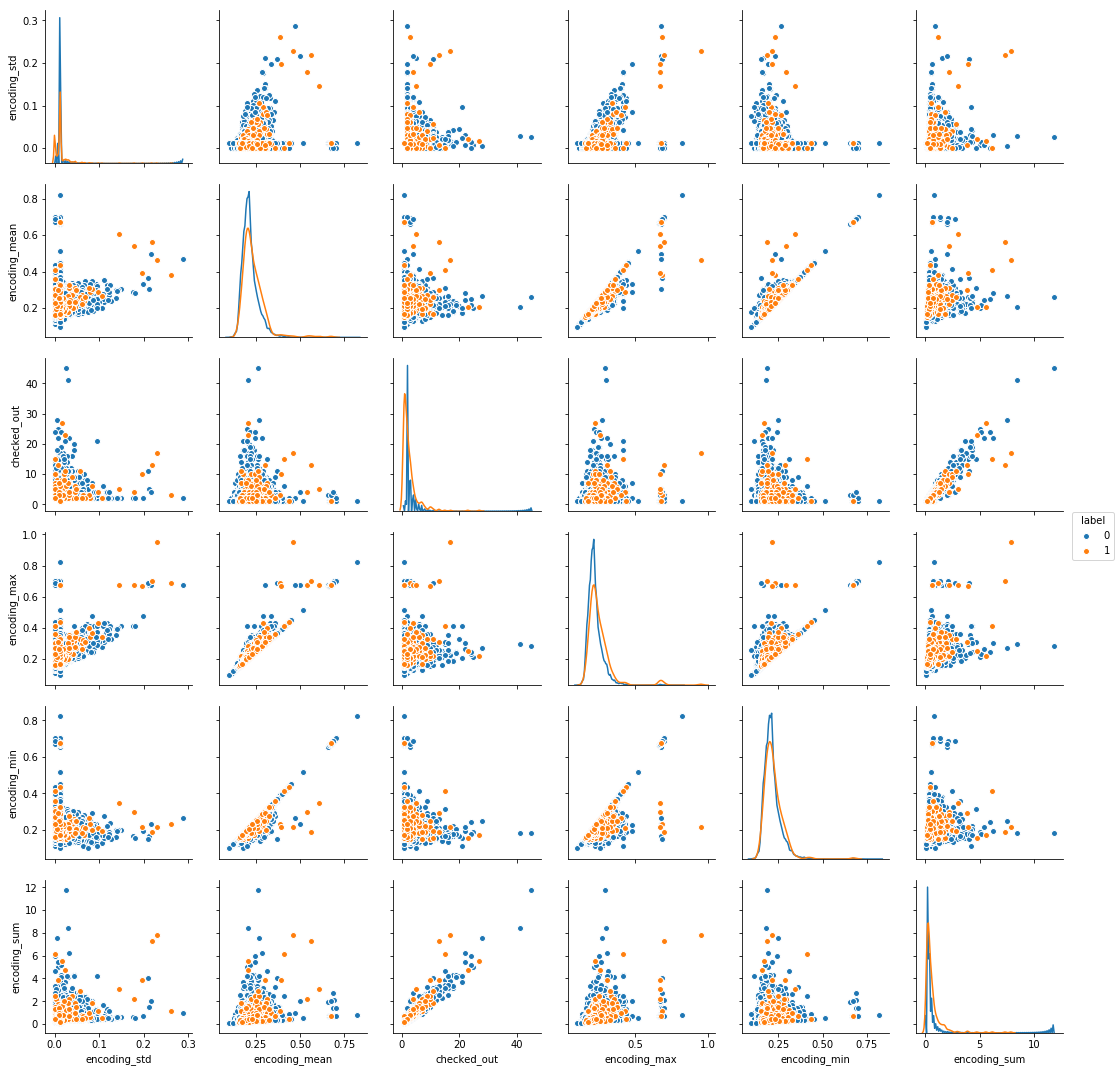

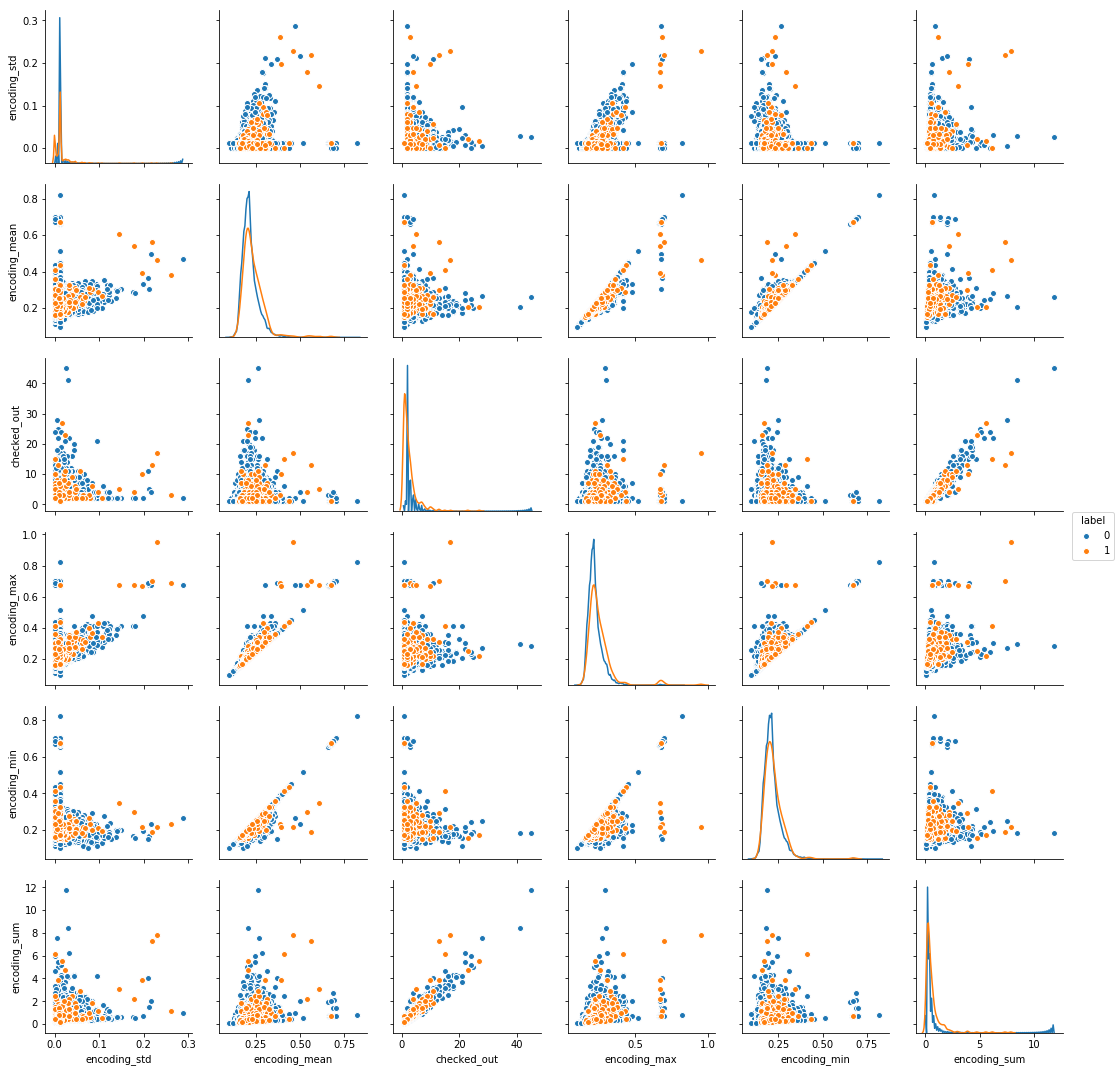

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns

# Aca con el pairplot podemos ver bien cuales son los features que mejor separan a los grupos. 
# A simple vista usar el encoding_mean y checked_out (cantidad de checkouts) parece juntar bastante a los compradores
# hacia abajo a la izquierda.
# Otra que vale la pena mencionar es encoding_std con checked_out que junta a la mayoría de los compradores al rincon.

features = ['encoding_std', 'encoding_mean', 'checked_out', 'encoding_max', 'encoding_min', 'encoding_sum']
sns.pairplot(stats, vars=features, hue='label', diag_kind='kde', kind='scatter')
plt.show()